# Выбор нефтяной скважины для ее дальнейшей разработке

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [27]:
!pip install phik -q

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy import stats as st
from phik.report import correlation_report, plot_correlation_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, LabelEncoder,
                                   StandardScaler, RobustScaler)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, mean_squared_error, make_scorer

## Загрузка и подготовка данных

In [3]:
for i, path in enumerate (['geo_data_0.csv', 'geo_data_1.csv', 'geo_data_2.csv']):
    data_path = os.path.join(os.getcwd(), path)
    if i == 0:
        geo_data_0 = pd.read_csv(data_path)
    elif i == 1:
        geo_data_1 = pd.read_csv(data_path)
    else:
        geo_data_2 = pd.read_csv(data_path)

### Датафрейм `geo_data_0`

#### Обработка дубликатов

In [4]:
display(geo_data_0.head(3))
geo_data_0.info()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Данные отображаются корректно. Явных пропусков в данных нет.

Рассмотрим датафрейм на наличие дубликатов

In [5]:
display('Количество явных дубликатов: {}'.format(geo_data_0.duplicated().sum()))
display('Количество явных дубликатов по id: {}'.format(geo_data_0['id'].duplicated().sum()))

'Количество явных дубликатов: 0'

'Количество явных дубликатов по id: 10'

In [6]:
display(geo_data_0[geo_data_0['id'].duplicated()])
display(geo_data_0[geo_data_0['id'] == 'HZww2'])

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695


Так как `id` не может указывать сразу на несколько скважин с разными признаками, сбросим найденные дубликаты.

In [7]:
geo_data_0 = geo_data_0.drop_duplicates(subset='id')
display(geo_data_0['id'].duplicated().sum())

0

#### Установка `id` в индексы

In [8]:
geo_data_0 = geo_data_0.set_index('id')

### Датафрейм `geo_data_1`

#### Обработка дубликатов

In [10]:
display(geo_data_1.head(3))
geo_data_1.info()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Данные отображаются корректно. Явных пропусков в данных нет.

Рассмотрим датафрейм на наличие дубликатов

In [11]:
display('Количество явных дубликатов: {}'.format(geo_data_1.duplicated().sum()))
display('Количество явных дубликатов по id: {}'.format(geo_data_1['id'].duplicated().sum()))

'Количество явных дубликатов: 0'

'Количество явных дубликатов по id: 4'

In [12]:
display(geo_data_1[geo_data_1['id'].duplicated()])
display(geo_data_1[geo_data_1['id'] == 'LHZR0'])

,id,f0,f1,f2,product
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625


Так как `id` не может указывать сразу на несколько скважин с разными признаками, сбросим найденные дубликаты.

In [13]:
geo_data_1 = geo_data_1.drop_duplicates(subset='id')
display(geo_data_1['id'].duplicated().sum())

0

#### Установка `id` в индексы

In [14]:
geo_data_1 = geo_data_1.set_index('id')

### Датафрейм `geo_data_2`

#### Обработка дубликатов

In [16]:
display(geo_data_2.head(3))
geo_data_2.info()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Данные отображаются корректно. Явных пропусков в данных нет.

Рассмотрим датафрейм на наличие дубликатов

In [17]:
display('Количество явных дубликатов: {}'.format(geo_data_2.duplicated().sum()))
display('Количество явных дубликатов по id: {}'.format(geo_data_2['id'].duplicated().sum()))

'Количество явных дубликатов: 0'

'Количество явных дубликатов по id: 4'

In [18]:
display(geo_data_2[geo_data_2['id'].duplicated()])
display(geo_data_2[geo_data_2['id'] == 'xCHr8'])

,id,f0,f1,f2,product
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


,id,f0,f1,f2,product
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Так как `id` не может указывать сразу на несколько скважин с разными признаками, сбросим найденные дубликаты.

In [19]:
geo_data_2 = geo_data_2.drop_duplicates(subset='id')
display(geo_data_2['id'].duplicated().sum())

0

#### Установка `id` в индексы

In [20]:
geo_data_2 = geo_data_2.set_index('id')

## Исследовательский и корреляционный  анализ данных

### Анализ датафрейма `geo_data_0`

#### Статистический анализ

**Построим графики `boxplot` для визуализации распределения значений входных и целевого признака**

,f0,f1,f2,product
count,99990.000000,99990.000000,99990.000000,99990.000000
mean,0.500454,0.250141,2.502629,92.499684
std,0.871844,0.504430,3.248149,44.288304
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072572,-0.200877,0.287784,56.497069
50%,0.502405,0.250252,2.515969,91.847928
75%,1.073626,0.700640,4.715035,128.563699
max,2.362331,1.343769,16.003790,185.364347


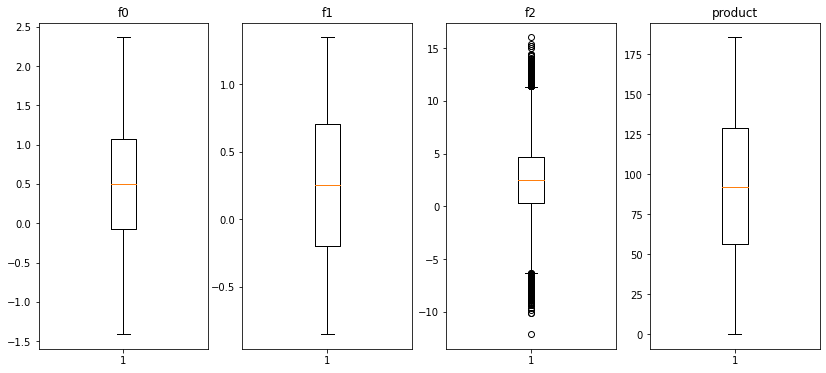

In [25]:
fig, ax = plt.subplots(1, len(geo_data_0.columns), figsize=(14, 6))

display(geo_data_0.describe())
for i, col in enumerate(geo_data_0.columns):
    ax[i].boxplot(geo_data_0[col])
    ax[i].set_title(col)
    

plt.show()

Во входном признаке `f2` наблюдаются выбросы как в большую, так и в меньшую сторону.

**Построим гистограмы для визуализации распределений**

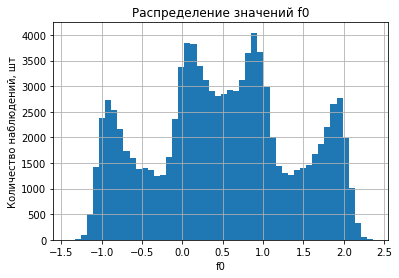

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


'Распределение f0 не относится к нормальному'

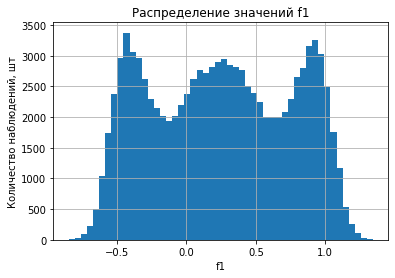

'Распределение f1 не относится к нормальному'

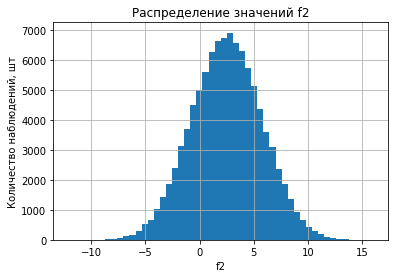

'Распределение f2 не относится к нормальному'

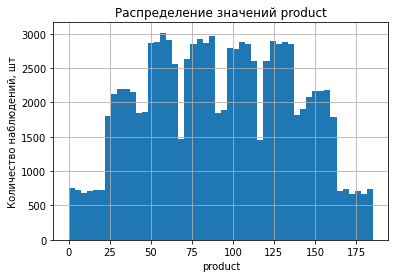

'Распределение product не относится к нормальному'

In [26]:
for col in geo_data_0.columns:
    plt.hist(geo_data_0[col], bins=50)
    plt.title(f'Распределение значений {col}')
    plt.xlabel(col)
    plt.ylabel('Количество наблюдений, шт')
    plt.grid()
    plt.show()
    val = st.shapiro(geo_data_0[col]).pvalue
    if val < 0.05:
        display(f'Распределение {col} не относится к нормальному')
    else:
        display(f'Распределение {col} относится к нормальному')

- Признак `f0` имеет необычное (синтетическое) распределение;
- Признак `f1` имеет необычное (синтетическое) распределение;
- Признак `f2` имеет распределение, приближенное к нормальному; 
- Их влияние на целевой признак видоизменяет его распределение.

#### Корреляционный анализ

**Построим матрицу корреляции**

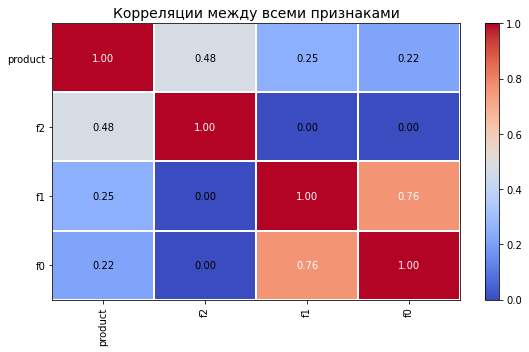

In [31]:
correlation_matrix = geo_data_0.phik_matrix(interval_cols=geo_data_0.columns)

plot_correlation_matrix(correlation_matrix.values, 
                        x_labels=correlation_matrix.columns, 
                        y_labels=correlation_matrix.index, 
                        vmin=0, vmax=1, color_map="coolwarm", 
                        title='Корреляции между всеми признаками', 
                        fontsize_factor=1, 
                        figsize=(8, 5))
plt.tight_layout()

В процессе проведения корреляционного анализа были обнаружены следующие **взаимосвязи**:
- Высокая корреляция (**0.76**) между входными признаками `f0` и `f1`.
- Умеренная корреляция (**0.48**) между входным признаком `f2` и целевым признаком `product`.

**Построим диаграммы рассеивания**

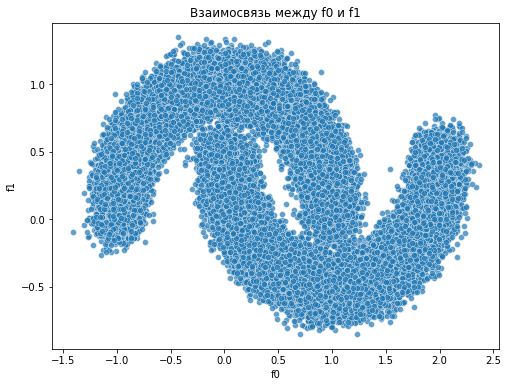

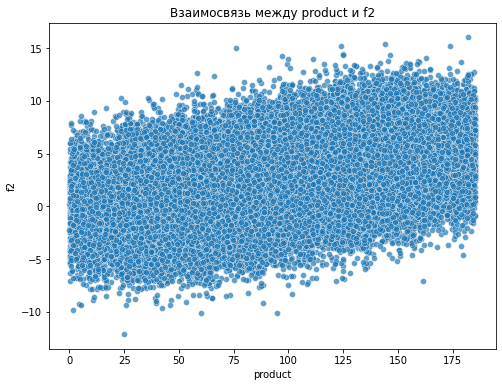

In [32]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=geo_data_0, x='f0', y='f1', alpha=0.7)
plt.title('Взаимосвязь между f0 и f1')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=geo_data_0, x='product', y='f2', alpha=0.7)
plt.title('Взаимосвязь между product и f2')
plt.show()

Диаграммы рассеивания еще раз подтверждают, что значения входных признаков `f0` и `f1` синтетические.

### Анализ датафрейма `geo_data_1`

#### Статистический анализ

**Построим графики `boxplot` для визуализации распределения значений входных и целевого признака**

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,1.141209,-4.796608,2.494501,68.823916
std,8.965815,5.119906,1.703579,45.944663
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011475,57.085625
75%,8.620964,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


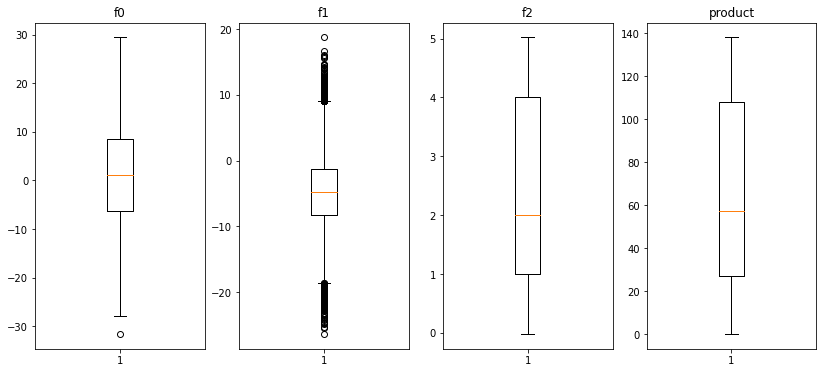

In [33]:
fig, ax = plt.subplots(1, len(geo_data_1.columns), figsize=(14, 6))

display(geo_data_1.describe())
for i, col in enumerate(geo_data_1.columns):
    ax[i].boxplot(geo_data_1[col])
    ax[i].set_title(col)
    

plt.show()

Во входном признаке `f1` наблюдаются выбросы как в большую, так и в меньшую сторону.

**Построим гистограмы для визуализации распределений**

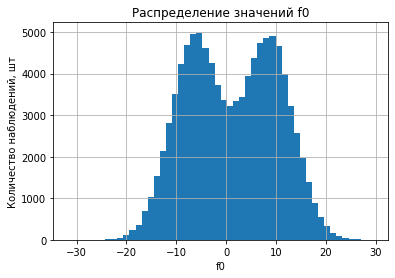

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


'Распределение f0 не относится к нормальному'

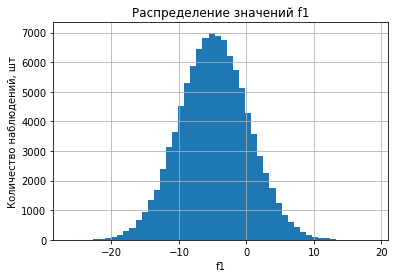

'Распределение f1 относится к нормальному'

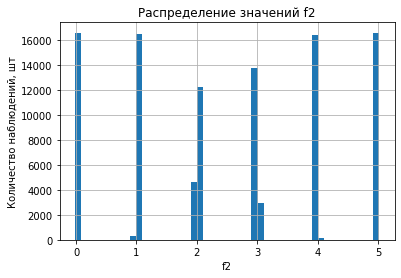

'Распределение f2 не относится к нормальному'

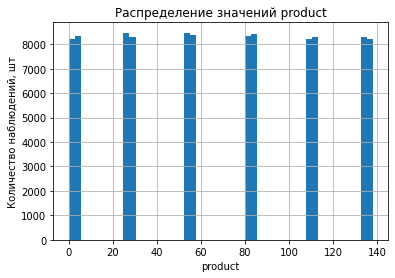

'Распределение product не относится к нормальному'

In [34]:
for col in geo_data_1.columns:
    plt.hist(geo_data_1[col], bins=50)
    plt.title(f'Распределение значений {col}')
    plt.xlabel(col)
    plt.ylabel('Количество наблюдений, шт')
    plt.grid()
    plt.show()
    val = st.shapiro(geo_data_1[col]).pvalue
    if val < 0.05:
        display(f'Распределение {col} не относится к нормальному')
    else:
        display(f'Распределение {col} относится к нормальному')

In [38]:
display(geo_data_1['f2'].nunique())
display(geo_data_1['product'].nunique())

99996

12

- Признак `f0` имеет распределение, приближенное к бимодальному;
- Признак `f1` имеет распределение, приближенное к нормальному; 
- Признак `f2` имеет распределение с 12 характерными "точками тяготения";
- Целевой признак `product` распределен по 12 уникальным значениям.

#### Корреляционный анализ

**Построим матрицу корреляции**

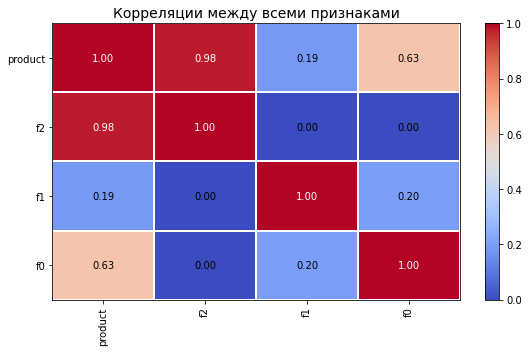

In [39]:
correlation_matrix = geo_data_1.phik_matrix(interval_cols=geo_data_1.columns)

plot_correlation_matrix(correlation_matrix.values, 
                        x_labels=correlation_matrix.columns, 
                        y_labels=correlation_matrix.index, 
                        vmin=0, vmax=1, color_map="coolwarm", 
                        title='Корреляции между всеми признаками', 
                        fontsize_factor=1, 
                        figsize=(8, 5))
plt.tight_layout()

В процессе проведения корреляционного анализа были обнаружены следующие **взаимосвязи**:
- Весьма высокая корреляция (**0.98**) между входным признаком `f2` и `product`.
- Заметная корреляция (**0.68**) между входным признаком `f0` и целевым признаком `product`.

**Построим диаграммы рассеивания**

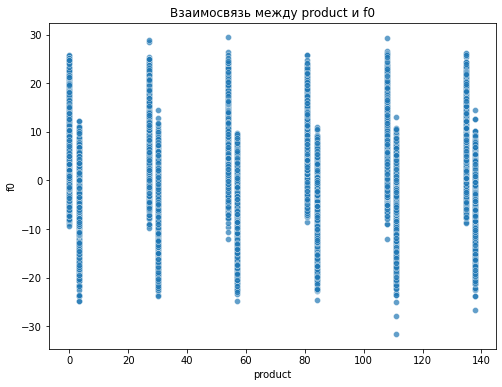

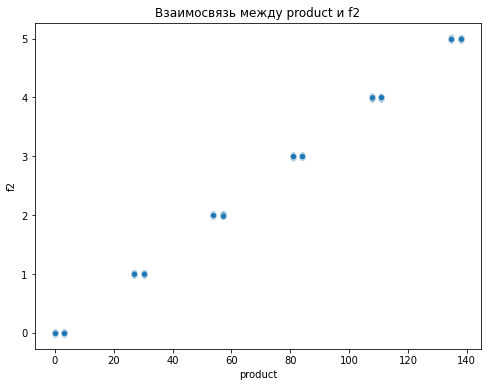

In [40]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=geo_data_1, x='product', y='f0', alpha=0.7)
plt.title('Взаимосвязь между product и f0')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=geo_data_1, x='product', y='f2', alpha=0.7)
plt.title('Взаимосвязь между product и f2')
plt.show()

### Анализ датафрейма `geo_data_2`

#### Статистический анализ

**Построим графики `boxplot` для визуализации распределения значений входных и целевого признака**

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,0.002002,-0.002159,2.495084,94.998342
std,1.732052,1.730397,3.473482,44.749573
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162328,-1.174841,0.130269,59.450028
50%,0.009424,-0.009661,2.484236,94.925026
75%,1.158477,1.163523,4.858720,130.586815
max,7.238262,7.844801,16.739402,190.029838


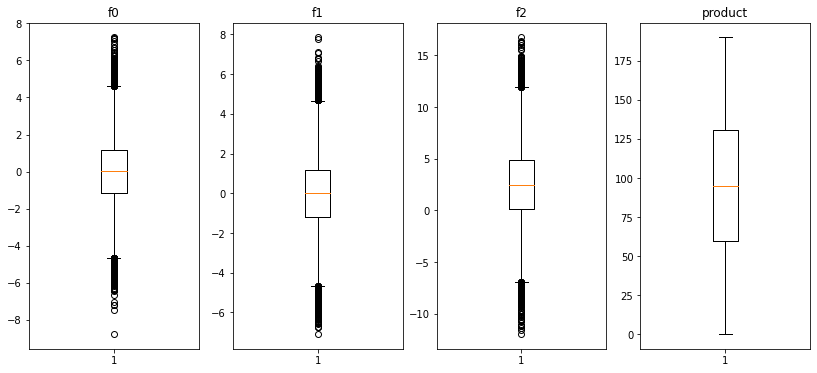

In [41]:
fig, ax = plt.subplots(1, len(geo_data_2.columns), figsize=(14, 6))

display(geo_data_2.describe())
for i, col in enumerate(geo_data_2.columns):
    ax[i].boxplot(geo_data_2[col])
    ax[i].set_title(col)
    

plt.show()

Во всех входных признаках наблюдаются выбросы как в большую, так и в меньшую сторону.

**Построим гистограмы для визуализации распределений**

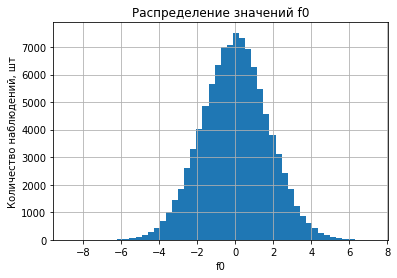

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


'Распределение f0 относится к нормальному'

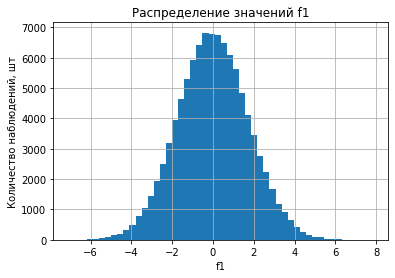

'Распределение f1 относится к нормальному'

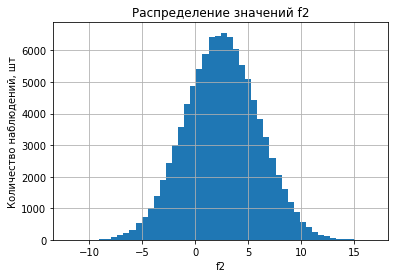

'Распределение f2 не относится к нормальному'

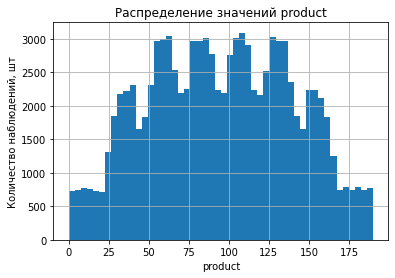

'Распределение product не относится к нормальному'

In [42]:
for col in geo_data_2.columns:
    plt.hist(geo_data_2[col], bins=50)
    plt.title(f'Распределение значений {col}')
    plt.xlabel(col)
    plt.ylabel('Количество наблюдений, шт')
    plt.grid()
    plt.show()
    val = st.shapiro(geo_data_2[col]).pvalue
    if val < 0.05:
        display(f'Распределение {col} не относится к нормальному')
    else:
        display(f'Распределение {col} относится к нормальному')

- Признак `f0` имеет нормальное распределение;
- Признак `f1` имеет нормальное распределение; 
- Признак `f2` имеет распределение, приближенное к нормальному;
- Целевой признак `product` имеет необычное распределение с пиками.

#### Корреляционный анализ

**Построим матрицу корреляции**

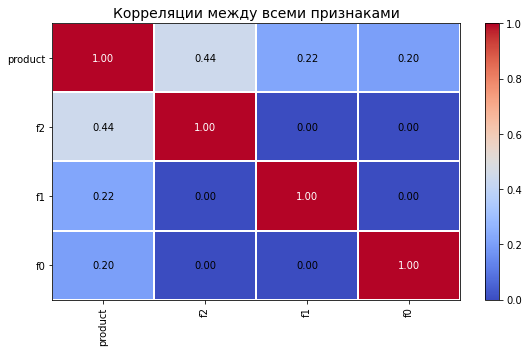

In [43]:
correlation_matrix = geo_data_2.phik_matrix(interval_cols=geo_data_2.columns)

plot_correlation_matrix(correlation_matrix.values, 
                        x_labels=correlation_matrix.columns, 
                        y_labels=correlation_matrix.index, 
                        vmin=0, vmax=1, color_map="coolwarm", 
                        title='Корреляции между всеми признаками', 
                        fontsize_factor=1, 
                        figsize=(8, 5))
plt.tight_layout()

В процессе проведения корреляционного анализа были обнаружены следующие **взаимосвязи**:
- Умеренная корреляция (**0.44**) между входным признаком `f2` и целевым признаком `product`.

**Построим диаграммы рассеивания**

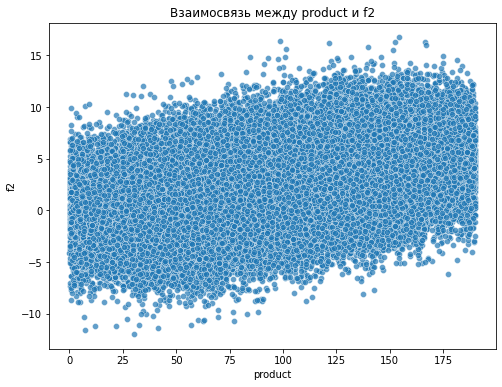

In [45]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=geo_data_2, x='product', y='f2', alpha=0.7)
plt.title('Взаимосвязь между product и f2')
plt.show()

### Проверка соответствия объема запасов в скажинах по всем датафреймам

**Н0: Среднее значение объема запаса в скажинах в датафреймах `geo_data_0` и `geo_data_1` равны.**

**Н1: Среднее значение объема запаса в скажинах в датафреймах `geo_data_0` и `geo_data_1` не равны.**

In [46]:
display('Среднее значение объема запаса в скважинах в датафрейме geo_data_0: {:.3f}'.format(geo_data_0['product'].mean()))
display('Среднее значение объема запаса в скважинах в датафрейме geo_data_1: {:.3f}'.format(geo_data_1['product'].mean()))

alpha = 0.01
result = st.ttest_ind(geo_data_0['product'], geo_data_1['product'])
display('pvalue равен: {:.3f}'.format(result.pvalue))
if result.pvalue < alpha:
    display('Объем запаса в скважинах из geo_data_0 отличается от объема запаса в скважинах из geo_data_1')
else:
    display('Объем запаса в скважинах из geo_data_0 не отличается от объема запаса в скважинах из geo_data_1')

'Среднее значение объема запаса в скважинах в датафрейме geo_data_0: 92.500'

'Среднее значение объема запаса в скважинах в датафрейме geo_data_1: 68.824'

'pvalue равен: 0.000'

'Объем запаса в скважинах из geo_data_0 отличается от объема запаса в скважинах из geo_data_1'

**Н0: Среднее значение объема запаса в скажинах в датафреймах `geo_data_0` и `geo_data_2` равны.**

**Н1: Среднее значение объема запаса в скажинах в датафреймах `geo_data_0` и `geo_data_2` не равны.**

In [47]:
display('Среднее значение объема запаса в скважинах в датафрейме geo_data_0: {:.3f}'.format(geo_data_0['product'].mean()))
display('Среднее значение объема запаса в скважинах в датафрейме geo_data_2: {:.3f}'.format(geo_data_2['product'].mean()))

alpha = 0.01
result = st.ttest_ind(geo_data_0['product'], geo_data_2['product'])
display('pvalue равен: {:.3f}'.format(result.pvalue))
if result.pvalue < alpha:
    display('Объем запаса в скважинах из geo_data_0 отличается от объема запаса в скважинах из geo_data_2')
else:
    display('Объем запаса в скважинах из geo_data_0 не отличается от объема запаса в скважинах из geo_data_2')

'Среднее значение объема запаса в скважинах в датафрейме geo_data_0: 92.500'

'Среднее значение объема запаса в скважинах в датафрейме geo_data_2: 94.998'

'pvalue равен: 0.000'

'Объем запаса в скважинах из geo_data_0 отличается от объема запаса в скважинах из geo_data_2'

**Н0: Среднее значение объема запаса в скажинах в датафреймах `geo_data_1` и `geo_data_2` равны.**

**Н1: Среднее значение объема запаса в скажинах в датафреймах `geo_data_1` и `geo_data_2` не равны.**

In [48]:
display('Среднее значение объема запаса в скважинах в датафрейме geo_data_0: {:.3f}'.format(geo_data_1['product'].mean()))
display('Среднее значение объема запаса в скважинах в датафрейме geo_data_2: {:.3f}'.format(geo_data_2['product'].mean()))

alpha = 0.01
result = st.ttest_ind(geo_data_1['product'], geo_data_2['product'])
display('pvalue равен: {:.3f}'.format(result.pvalue))
if result.pvalue < alpha:
    display('Объем запаса в скважинах из geo_data_1 отличается от объема запаса в скважинах из geo_data_2')
else:
    display('Объем запаса в скважинах из geo_data_1 не отличается от объема запаса в скважинах из geo_data_2')

'Среднее значение объема запаса в скважинах в датафрейме geo_data_0: 68.824'

'Среднее значение объема запаса в скважинах в датафрейме geo_data_2: 94.998'

'pvalue равен: 0.000'

'Объем запаса в скважинах из geo_data_1 отличается от объема запаса в скважинах из geo_data_2'

## Обучение и проверка модели

In [49]:
RANDOM_STATE = 7

In [50]:
def model_process(data):
    X = data.drop(columns=['product'])
    y = data['product']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
    
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    new_data = pd.DataFrame(y_val.values, columns=['true'], index=y_val.index)
    new_data['predict'] = y_pred
    
    return new_data, rmse

### Обучение модели по региону датафрейма `geo_data_0`

In [51]:
geo_0, rmse_0 = model_process(geo_data_0)

In [52]:
display(geo_0.head())
display(f'Корень среднеквадратичной ошибки модели равен: {round(rmse_0, 2)}')
display('Средний запас истинного сырья: {}'.format(round(geo_0['true'].mean(), 2)))
display('Средний запас предсказанного сырья: {}'.format(round(geo_0['predict'].mean(), 2)))

,true,predict
id,,
sYDqj,149.452928,94.122251
l4HXy,105.531034,109.023793
zpwOJ,123.636212,132.779008
dHJGG,181.896776,116.756404
Y2gMk,31.013429,73.302112


'Корень среднеквадратичной ошибки модели равен: 37.62'

'Средний запас истинного сырья: 92.55'

'Средний запас предсказанного сырья: 92.43'

**Вывод:** Модель предсказывает данные с высокой дисперсией (41% от среднего значения). Однако в целом совокупный предсказанный средний запас сырья, примерно, равен совокупному истинному среднему запасу.

### Обучение модели по региону датафрейма `geo_data_1`

In [53]:
geo_1, rmse_1 = model_process(geo_data_1)

In [54]:
display(geo_1.head())
display(f'Корень среднеквадратичной ошибки модели равен: {round(rmse_1, 2)}')
display('Средний запас истинного сырья: {}'.format(round(geo_1['true'].mean(), 2)))
display('Средний запас предсказанного сырья: {}'.format(round(geo_1['predict'].mean(), 2)))

,true,predict
id,,
0sY7R,107.813044,107.778428
TM8f3,107.813044,108.255320
hVioD,107.813044,109.018915
COAFK,80.859783,81.361908
qf3ai,84.038886,82.907310


'Корень среднеквадратичной ошибки модели равен: 0.89'

'Средний запас истинного сырья: 69.42'

'Средний запас предсказанного сырья: 69.44'

**Вывод:** Модель предсказывает данные с низкой дисперсией (1% от среднего значения). В целом совокупный предсказанный средний запас сырья, примерно, равен совокупному истинному среднему запасу.

### Обучение модели по региону датафрейма `geo_data_2`

In [55]:
geo_2, rmse_2 = model_process(geo_data_2)

In [56]:
display(geo_2.head())
display(f'Корень среднеквадратичной ошибки модели равен: {round(rmse_2, 2)}')
display('Средний запас истинного сырья: {}'.format(round(geo_2['true'].mean(), 2)))
display('Средний запас предсказанного сырья: {}'.format(round(geo_2['predict'].mean(), 2)))

,true,predict
id,,
J6jxk,124.909676,148.272987
FMgE7,86.934569,114.872169
oQgpT,146.474270,97.828648
pxqo5,62.926135,90.250439
LR9s1,167.403031,131.920173


'Корень среднеквадратичной ошибки модели равен: 39.93'

'Средний запас истинного сырья: 95.16'

'Средний запас предсказанного сырья: 94.93'

**Вывод:** Модель предсказывает данные с высокой дисперсией (42% от среднего значения). В целом совокупный предсказанный средний запас сырья, примерно, равен совокупному истинному среднему запасу.

### Вывод по разделу

В процессе работы были обучены три модели линейной регрессии для каждого региона. **Наилучший** результат был получен у модели **региона № 1 (RMSE = 0.89)**. По региону № 0 и № 2 модели продемонстрировали плохие результаты **(RMSE = 37.62-39.93)** с учетом предсказанных средних запасов сырья **92.43-94.93**.

## Подготовка к расчёту прибыли

In [57]:
reg_budget = 10_000_000_000
wells = 200
income_for_barrel = 450

In [58]:
well_budget = reg_budget / wells
oil_vol = well_budget / (income_for_barrel * 1_000)
display(f'Бюджет на разработку одной новой скважины равен: {well_budget} рублей')
display(f'Достаточный объем сырья для безубыточной разработки новой скважины: {round(oil_vol, 2)} \
тыс. баррель')

'Бюджет на разработку одной новой скважины равен: 50000000.0 рублей'

'Достаточный объем сырья для безубыточной разработки новой скважины: 111.11 тыс. баррель'

In [59]:
display('В регионе № 0 средний запас сырья скажин меньше, \
чем рассчитанный объем для безубыточной разработки: {} < \
{}'.format(round(geo_data_0['product'].mean(), 2), round(oil_vol, 2)))

display('В регионе № 1 средний запас сырья скажин меньше, \
чем рассчитанный объем для безубыточной разработки: {} < \
{}'.format(round(geo_data_1['product'].mean(), 2), round(oil_vol, 2)))

display('В регионе № 2 средний запас сырья скажин меньше, \
чем рассчитанный объем для безубыточной разработки: {} < \
{}'.format(round(geo_data_2['product'].mean(), 2), round(oil_vol, 2)))

'В регионе № 0 средний запас сырья скажин меньше, чем рассчитанный объем для безубыточной разработки: 92.5 < 111.11'

'В регионе № 1 средний запас сырья скажин меньше, чем рассчитанный объем для безубыточной разработки: 68.82 < 111.11'

'В регионе № 2 средний запас сырья скажин меньше, чем рассчитанный объем для безубыточной разработки: 95.0 < 111.11'

**Вывод:** 
- Бюджет на разработку одной новой скважины равен 50 млн. рублей;
- Достаточный объем сырья для безубыточной разработки новой скважины равен 111.11 тыс. баррель;
- Средний запас сырья на одну скважину по всем регионам меньше, чем рассчитанный объем для безубыточной разработки.

## Расчёт прибыли и рисков 

In [61]:
def profit(data):
    top_wells = data.sort_values(by='predict', ascending=False)['true'][:200]
    income = top_wells.sum() * income_for_barrel * 1_000
    profit = income - reg_budget
    
    return profit

In [69]:
state = np.random.RandomState(7)

def bootstrap(data):
    true_vol = pd.DataFrame(data['true'], index=data['true'].index, columns=['true'])
    values = []
    for i in range(1_000):
        subsample = data['predict'].sample(n=500, replace=True, random_state=state)
        subsample = pd.DataFrame(subsample, index=subsample.index, columns=['predict'])
        subsample = subsample.join(true_vol, how='inner')
        subsample_top = subsample.sort_values(by='predict', ascending=False)['true'][:200]
        income = subsample_top.sum() * income_for_barrel * 1_000
        profit = income - reg_budget
        values.append(profit)
    
    values = pd.Series(values)
    
    avr_profit = values.mean()
    lower = values.quantile(q=0.025)
    upper = values.quantile(q=0.975)
    risk = values[values < 0].count() / 10
    
    return values, avr_profit, lower, upper, risk

### Расчет приыбли и рисков в регионе № 0

**Расчитаем прибыль по 200 лучшим скважинам**

In [62]:
profit_0 = profit(geo_0)
display(f'Прибыль по лучшим 200 скважинам в регионе № 0 равна: {round(profit_0, 2)} рублей')

'Прибыль по лучшим 200 скважинам в регионе № 0 равна: 3149112365.6 рублей'

**Построим распределение прибыли**

In [74]:
values_0, avr_profit_0, lower_0, upper_0, risk_0 = bootstrap(geo_0)

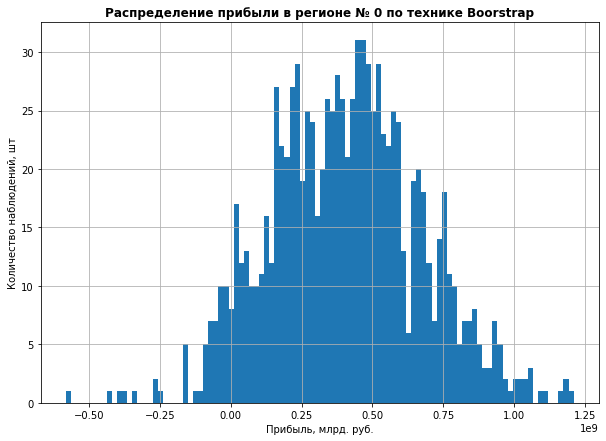

In [75]:
plt.figure(figsize=(10, 7))
plt.title('Распределение прибыли в регионе № 0 по технике Boorstrap', fontweight='bold')
plt.hist(values_0, bins=100)
plt.ylabel('Количество наблюдений, шт')
plt.xlabel('Прибыль, млрд. руб.')
plt.grid()
plt.show()

In [76]:
display(f'Средняя прибыль равна {round(avr_profit_0, 2)}')
display(f'95%-й доверительный интервал прибыли лежит в диапазоне {round(lower_0, 2)} - {round(upper_0, 2)}')
display(f'Риск убытков составляет {risk_0} %')

'Средняя прибыль равна 405716874.59'

'95%-й доверительный интервал прибыли лежит в диапазоне -62353902.47 - 932339200.52'

'Риск убытков составляет 5.7 %'

### Расчет приыбли и рисков в регионе № 1

**Расчитаем прибыль по 200 лучшим скважинам**

In [73]:
profit_1 = profit(geo_1)
display(f'Прибыль по лучшим 200 скважинам в регионе № 1 равна: {round(profit_1, 2)} рублей')

'Прибыль по лучшим 200 скважинам в регионе № 1 равна: 2415086696.68 рублей'

**Построим распределение прибыли**

In [77]:
values_1, avr_profit_1, lower_1, upper_1, risk_1 = bootstrap(geo_1)

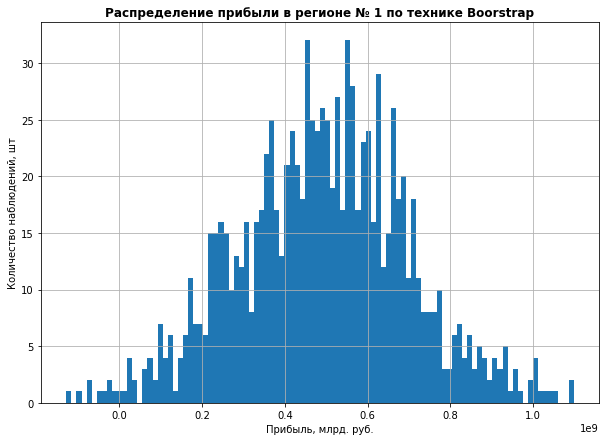

In [78]:
plt.figure(figsize=(10, 7))
plt.title('Распределение прибыли в регионе № 1 по технике Boorstrap', fontweight='bold')
plt.hist(values_1, bins=100)
plt.ylabel('Количество наблюдений, шт')
plt.xlabel('Прибыль, млрд. руб.')
plt.grid()
plt.show()

In [79]:
display(f'Средняя прибыль равна {round(avr_profit_1, 2)}')
display(f'95%-й доверительный интервал прибыли лежит в диапазоне {round(lower_1, 2)} - {round(upper_1, 2)}')
display(f'Риск убытков составляет {risk_1} %')

'Средняя прибыль равна 491476680.94'

'95%-й доверительный интервал прибыли лежит в диапазоне 90181333.21 - 913058690.85'

'Риск убытков составляет 1.0 %'

### Расчет приыбли и рисков в регионе № 2

**Расчитаем прибыль по 200 лучшим скважинам**

In [80]:
profit_2 = profit(geo_2)
display(f'Прибыль по лучшим 200 скважинам в регионе № 2 равна: {round(profit_2, 2)} рублей')

'Прибыль по лучшим 200 скважинам в регионе № 2 равна: 2772501933.25 рублей'

**Построим распределение прибыли**

In [81]:
values_2, avr_profit_2, lower_2, upper_2, risk_2 = bootstrap(geo_2)

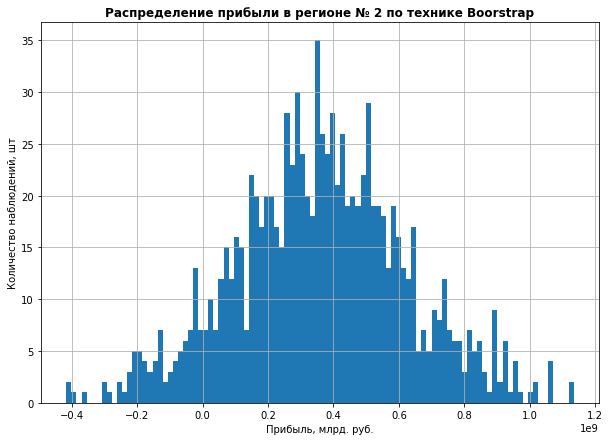

In [82]:
plt.figure(figsize=(10, 7))
plt.title('Распределение прибыли в регионе № 2 по технике Boorstrap', fontweight='bold')
plt.hist(values_2, bins=100)
plt.ylabel('Количество наблюдений, шт')
plt.xlabel('Прибыль, млрд. руб.')
plt.grid()
plt.show()

In [83]:
display(f'Средняя прибыль равна {round(avr_profit_2, 2)}')
display(f'95%-й доверительный интервал прибыли лежит в диапазоне {round(lower_2, 2)} - {round(upper_2, 2)}')
display(f'Риск убытков составляет {risk_2} %')

'Средняя прибыль равна 361453129.72'

'95%-й доверительный интервал прибыли лежит в диапазоне -175941596.64 - 894638241.21'

'Риск убытков составляет 8.8 %'

### Рекомендации по выбору региона

Для разработки новых скважин предлагается провести работы в **регионе № 1**, так как:
- Модель машинного обучения показала лучшую метрику (**RMSE=0.89**), что свидетельствует о минимальных рисках при разработке скважин;
- Несмотря на малый средний запас сырья в скважинах (**69.42**), распределение прибыли по техники bootstrap оказалось наибольшим (**90 - 913 млн. рублей**);
- Максимальная рассчитаная прибыль по данному региону равна **2.4 млрд. рублей (маржинальность 24%)**;
- Средняя расчитанная прибыль по данному региону **419 млн.рублей (маржинальность 4.2%)**;
- Риск убытков по данному региону минимальный среди всех регионов - **1.0 %**.